<a href="https://colab.research.google.com/github/roboy88/FanDuel-Bonus-Optimization-Engine/blob/main/FanDuel_Bonus_Optimization_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving sportsbook_customers.csv to sportsbook_customers.csv
Loaded: sportsbook_customers.csv — Shape: (1000, 10)


,customer_id,avg_bet_amount,win_rate,bonus_amount,bonus_used,total_deposit,days_since_last_bet,sportsbook_tier,churned,bonus_roi
0,1,23.46,0.31,10,7.71,279.71,19,Gold,0,0.7710
1,2,150.51,0.53,10,85.77,322.04,24,Platinum,0,8.5770
2,3,65.84,0.72,100,47.53,456.99,3,Silver,0,0.4753
3,4,45.65,0.64,10,18.44,306.86,9,Silver,0,1.8440
4,5,8.48,0.68,10,35.01,236.08,9,Platinum,0,3.5010


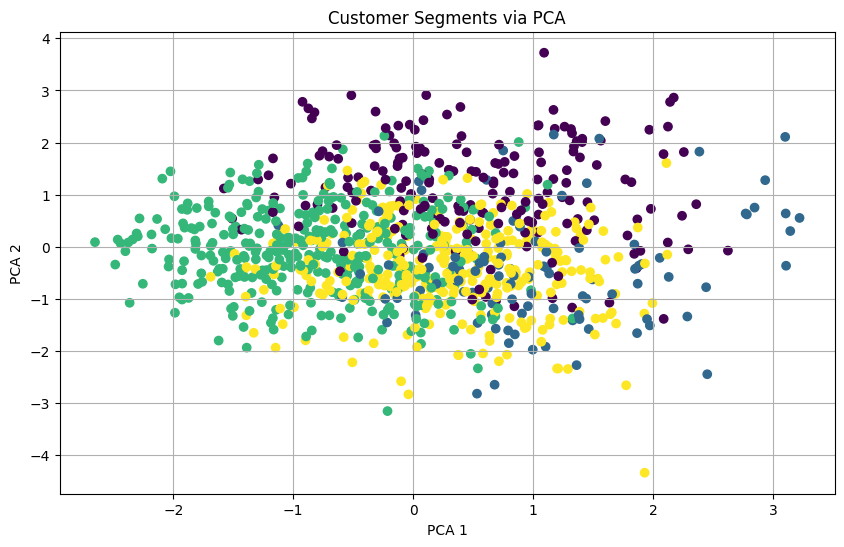

Cluster Summary:


,avg_bet_amount,win_rate,bonus_amount,bonus_used,total_deposit,days_since_last_bet
cluster,,,,,,
0,49.038041,0.500309,25.283505,64.062784,308.648196,28.458763
1,48.222178,0.522178,100.000000,24.633663,298.728020,27.168317
2,46.559151,0.473740,23.673740,12.442228,316.234350,43.554377
3,50.879787,0.535945,20.990854,13.527988,278.182439,14.625000


Model Performance:
RMSE: 1162295697.0797
R² Score: 0.9893


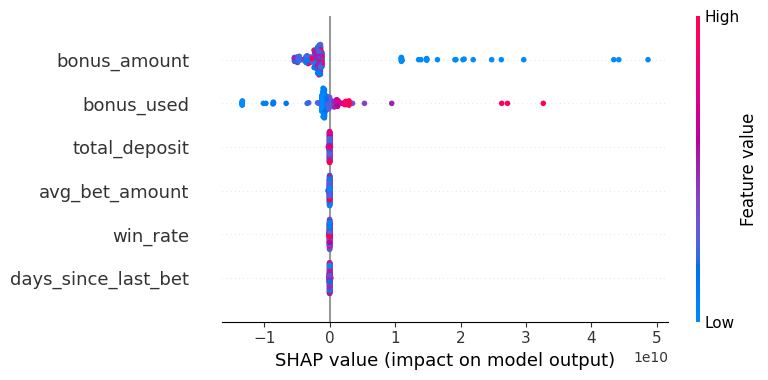

['fanduel_bonus_roi_model.pkl']

In [1]:
# Install dependencies
!pip install pandas numpy scikit-learn matplotlib seaborn shap --quiet

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import shap
import joblib
from google.colab import files
import io

# Upload sportsbook_customers.csv when prompted
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"Loaded: {filename} — Shape: {df.shape}")
display(df.head())

# Fill missing values
df.fillna(0, inplace=True)

# Define clustering features
cluster_features = [
    'avg_bet_amount',
    'win_rate',
    'bonus_amount',
    'bonus_used',
    'total_deposit',
    'days_since_last_bet'
]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cluster_features])

# Run KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Reduce dimensions with PCA for plotting
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)

# Plot clusters in 2D PCA space
plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['cluster'], cmap='viridis')
plt.title("Customer Segments via PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

# Display cluster profile summary
print("Cluster Summary:")
display(df.groupby("cluster")[cluster_features].mean())

# Create bonus ROI target
df['bonus_roi'] = df['bonus_used'] / (df['bonus_amount'] + 1e-9)

# Define features and target
feature_cols = [
    'avg_bet_amount',
    'win_rate',
    'bonus_amount',
    'bonus_used',
    'total_deposit',
    'days_since_last_bet'
]
X = df[feature_cols]
y = df['bonus_roi']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Model performance metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Model Performance:\nRMSE: {rmse:.4f}\nR² Score: {r2:.4f}")

# SHAP explainability
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Save model to file
joblib.dump(rf, "fanduel_bonus_roi_model.pkl")
